In [20]:
from numpy.linalg import svd
import numpy as np
from skimage import data
from skimage.color import rgb2gray
from skimage import img_as_float
import glob

In [21]:
%pwd

u'/data1/dbashir/courses/deeplearning1/nbs'

In [22]:
import os, sys

current_dir = os.getcwd()
DATA_HOME_DIR = current_dir+'/data/redux/'
NEW_DATA_DIR = current_dir+'/data/catsdogs-svd/'

In [23]:
def reconstruct_svd(image,k):
    U,S,V = svd(image, full_matrices=False)
    reconst_matrix = np.dot(U[:,:k], np.dot(np.diag(S[:k]), V[:k,:]))
    
    return reconst_matrix, S

Below, we'll populate the new data directory with rank 128 approximations of all the images from cats-dogs-redux.

In [24]:
from shutil import copy
import cv2
from PIL import Image
import pandas as pd

In [13]:
fromTrainDir = os.path.join(DATA_HOME_DIR, 'train')
catDirTrain = os.path.join(fromTrainDir, 'cats')
dogDirTrain = os.path.join(fromTrainDir, 'dogs')

toTrainDir = os.path.join(NEW_DATA_DIR, 'train')
toCatDir = os.path.join(toTrainDir,'cats')
toDogDir = os.path.join(toTrainDir, 'dogs')

k = 128

for image in os.listdir(catDirTrain):
    imagePath = os.path.join(catDirTrain,image)
    img = Image.open(imagePath)
    greyimg = rgb2gray(img_as_float(img))
    
    reconst_img, s = reconstruct_svd(greyimg, k)
    imageDir = os.path.join(toCatDir,image)

    cv2.imwrite(imageDir, reconst_img)

# for image in os.listdir(dogDirTrain):    
#     imagePath = os.path.join(dogDirTrain,image)
#     img = Image.open(imagePath)
#     greyimg = rgb2gray(img_as_float(img))
    
#     reconst_img, s = reconstruct_svd(greyimg, k)
#     imageDir = os.path.join(toDogDir,image)

#     cv2.imwrite(imageDir, reconst_img)

LinAlgError: SVD did not converge

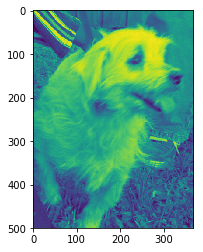

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

dogDirTrain = os.path.join(fromTrainDir, 'dogs')
img_name = 'dog.9.jpg'

testImg = os.path.join(dogDirTrain,img_name)

img = Image.open(testImg)
greyimg = rgb2gray(img_as_float(img))

reconst_img, s = reconstruct_svd(greyimg, k)
plt.imshow(reconst_img)

We'll copy over the validation and test data as-is, since we want to see how well the neural network does by validating and testing it on the real data.

In [17]:
%cd $NEW_DATA_DIR/train/dogs
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2995): os.rename(shuf[i], NEW_DATA_DIR+'/trash/' + shuf[i])

/data1/dbashir/courses/deeplearning1/nbs/data/catsdogs-svd/train/dogs


In [19]:
fromValidDir = os.path.join(DATA_HOME_DIR, 'valid')
catDirValid = os.path.join(fromValidDir, 'cats')
dogDirValid = os.path.join(fromValidDir, 'dogs')

toValidDir = os.path.join(NEW_DATA_DIR, 'valid')
toCatDirVal = os.path.join(toValidDir,'cats')
toDogDirVal = os.path.join(toValidDir, 'dogs')

for image in os.listdir(catDirValid):
    oldDir = os.path.join(catDirValid, image)
    
    newDir = os.path.join(toCatDirVal, image)
    
    copy(oldDir,newDir)
        
for image in os.listdir(dogDirValid):
    oldDir = os.path.join(dogDirValid, image)
    
    copy(oldDir,newDir)
    
    newDir = os.path.join(toDogDirVal, image)
    
    
fromTestDir = os.path.join(DATA_HOME_DIR, 'test')
unknownDir = os.path.join(fromTestDir, 'unknown')

toTestDir = os.path.join(NEW_DATA_DIR, 'test')
toUnknownDir = os.path.join(toTestDir,'unknown')

for image in os.listdir(unknownDir):
    oldDir = os.path.join(unknownDir, image)
    
    newDir = os.path.join(toUnknownDir, image)
    
    copy(oldDir,newDir)

# Get Batches

In [27]:
%cd ..

/data1/dbashir/courses/deeplearning1/nbs


In [31]:
%matplotlib inline
from __future__ import print_function, division
path = "data/catsdogs-svd/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

In [32]:
batch_size = 64

In [33]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 16544 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [34]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filename) = get_classes(path)

Found 16544 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


# Models

### Linear Model

In [35]:
def get_lin_model():
    model = Sequential([
        Lambda(norm_input, input_shape=(3,224,224)),
        Flatten(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [36]:
lm = get_lin_model()

NameError: global name 'norm_input' is not defined

### Single Hidden Layer

In [38]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
16544/16544 [==============================] - 169s - loss: 0.7587 - acc: 0.5667 - val_loss: 7.9402 - val_acc: 0.5070
Epoch 2/2
16544/16544 [==============================] - 149s - loss: 0.6274 - acc: 0.6479 - val_loss: 7.9333 - val_acc: 0.5078
Epoch 1/5
16544/16544 [==============================] - 155s - loss: 0.5743 - acc: 0.6982 - val_loss: 7.9356 - val_acc: 0.5074
Epoch 2/5
16544/16544 [==============================] - 148s - loss: 0.5312 - acc: 0.7386 - val_loss: 7.9479 - val_acc: 0.5066
Epoch 3/5
16544/16544 [==============================] - 149s - loss: 0.4772 - acc: 0.7762 - val_loss: 7.6164 - val_acc: 0.5214
Epoch 4/5
16544/16544 [==============================] - 148s - loss: 0.4230 - acc: 0.8156 - val_loss: 7.9309 - val_acc: 0.5070
Epoch 5/5
16544/16544 [==============================] - 149s - loss: 0.3569 - acc: 0.8563 - val_loss: 7.4205 - val_acc: 0.5318


### Single Conv Layer

In [39]:
def conv1(batches):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model

In [40]:
conv1(batches)

Epoch 1/2
16544/16544 [==============================] - 157s - loss: 0.7257 - acc: 0.6437 - val_loss: 8.1373 - val_acc: 0.4938
Epoch 2/2
16544/16544 [==============================] - 152s - loss: 0.4866 - acc: 0.7636 - val_loss: 8.0031 - val_acc: 0.5018
Epoch 1/4
16544/16544 [==============================] - 156s - loss: 0.3548 - acc: 0.8451 - val_loss: 7.9316 - val_acc: 0.5058
Epoch 2/4
16544/16544 [==============================] - 156s - loss: 0.2371 - acc: 0.9112 - val_loss: 6.6373 - val_acc: 0.5706
Epoch 3/4
16544/16544 [==============================] - 154s - loss: 0.1366 - acc: 0.9567 - val_loss: 7.3061 - val_acc: 0.5370
Epoch 4/4
16544/16544 [==============================] - 154s - loss: 0.0763 - acc: 0.9816 - val_loss: 7.8046 - val_acc: 0.5118


# That was a Dumb Idea

## Part 2: Let's actually do SVD w/ RGB channels!

In [25]:
import os,sys

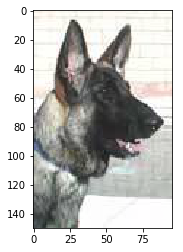

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

k = 128

dataPath = 'data/redux/'

trainDir = os.path.join(dataPath,'train')

dogDirTrain = os.path.join(trainDir, 'dogs')
img_name = 'dog.9999.jpg'

testImg = os.path.join(dogDirTrain,img_name)

img = np.array(Image.open(testImg))
#plt.imshow(img)
image_reconstructed = img

image_red = img[:,:,0]
image_green = img[:,:,1]
image_blue = img[:,:,2]
#plt.imshow(image_blue)

reconst_img_red, s = reconstruct_svd(image_red, k)
#plt.imshow(reconst_img_red)

reconst_img_green, s = reconstruct_svd(image_green, k)
#plt.imshow(reconst_img_green)
reconst_img_blue, s = reconstruct_svd(image_blue, k)
#plt.imshow(reconst_img_blue)


# #reconstruct image out of these channels
image_reconstructed[:,:,0] = reconst_img_red
image_reconstructed[:,:,1] = reconst_img_green
image_reconstructed[:,:,2] = reconst_img_blue
plt.imshow(image_reconstructed)

Looks like the testing worked! Let's try it on everything else.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

k = 128


fromTrainDir = os.path.join(DATA_HOME_DIR, 'train')
catDirTrain = os.path.join(fromTrainDir, 'cats')
dogDirTrain = os.path.join(fromTrainDir, 'dogs')

toTrainDir = os.path.join(NEW_DATA_DIR, 'train')
toCatDir = os.path.join(toTrainDir,'cats')
toDogDir = os.path.join(toTrainDir, 'dogs')

k = 128

for image in os.listdir(catDirTrain):
    imagePath = os.path.join(catDirTrain,image)
    
    img = np.array(Image.open(testImg))
    #initialize final thing
    image_reconstructed = img

    image_red = img[:,:,0]
    image_green = img[:,:,1]
    image_blue = img[:,:,2]
    
    reconst_img_red, s = reconstruct_svd(image_red, k)
    reconst_img_green, s = reconstruct_svd(image_green, k)
    reconst_img_blue, s = reconstruct_svd(image_blue, k)
    
    image_reconstructed[:,:,0] = reconst_img_red
    image_reconstructed[:,:,1] = reconst_img_green
    image_reconstructed[:,:,2] = reconst_img_blue
    
    imageDir = os.path.join(toCatDir,image)

    cv2.imwrite(imageDir, image_reconstructed)

In [27]:
for image in os.listdir(dogDirTrain):
    imagePath = os.path.join(dogDirTrain,image)
    
    img = np.array(Image.open(testImg))
    #initialize final thing
    image_reconstructed = img

    image_red = img[:,:,0]
    image_green = img[:,:,1]
    image_blue = img[:,:,2]
    
    reconst_img_red, s = reconstruct_svd(image_red, k)
    reconst_img_green, s = reconstruct_svd(image_green, k)
    reconst_img_blue, s = reconstruct_svd(image_blue, k)
    
    image_reconstructed[:,:,0] = reconst_img_red
    image_reconstructed[:,:,1] = reconst_img_green
    image_reconstructed[:,:,2] = reconst_img_blue
    
    imageDir = os.path.join(toDogDir,image)

    cv2.imwrite(imageDir, image_reconstructed)

# Now, the Models!

### Get Batches

In [28]:
%matplotlib inline
from __future__ import print_function, division
path = "data/catsdogs-svd/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink

Using cuDNN version 5103 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K40c (0000:81:00.0)
Using Theano backend.


In [29]:
batch_size = 64

In [30]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

Found 23000 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [31]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filename) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### Single Hidden Layer

In [32]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

model.optimizer.lr = 0.01
model.fit_generator(batches, batches.nb_sample, nb_epoch=5, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
23000/23000 [==============================] - 204s - loss: 0.6932 - acc: 0.4937 - val_loss: 5.8254 - val_acc: 0.4906
Epoch 2/2
23000/23000 [==============================] - 196s - loss: 0.6932 - acc: 0.4977 - val_loss: 7.2902 - val_acc: 0.5158
Epoch 1/5
23000/23000 [==============================] - 201s - loss: 0.6932 - acc: 0.4941 - val_loss: 6.7472 - val_acc: 0.4958
Epoch 2/5
23000/23000 [==============================] - 196s - loss: 0.6932 - acc: 0.5002 - val_loss: 7.6962 - val_acc: 0.4918
Epoch 3/5
23000/23000 [==============================] - 194s - loss: 0.6932 - acc: 0.4987 - val_loss: 8.0018 - val_acc: 0.4930
Epoch 4/5
11584/23000 [==============>...............] - ETA: 83s - loss: 0.6931 - acc: 0.5021

KeyboardInterrupt: 

### Single Conv Layer

In [ ]:
def conv1(batches):
    model = Sequential([
            BatchNormalization(axis=1, input_shape=(3,224,224)),
            Convolution2D(32,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Convolution2D(64,3,3, activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dense(200, activation='relu'),
            BatchNormalization(),
            Dense(2, activation='softmax')
        ])

    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    model.optimizer.lr = 0.001
    model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                     nb_val_samples=val_batches.nb_sample)
    return model

In [ ]:
conv1(batches)

### VGG

In [33]:
from vgg16 import Vgg16

In [34]:
train_path=path + '/train/'
valid_path=path + '/valid/'
results_path= os.path.join(path,'results')

In [35]:
vgg = Vgg16()

In [36]:
batch_size=64
no_of_epochs=3

In [37]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [ ]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 439s - loss: 8.0456 - acc: 0.4999 - val_loss: 8.1719 - val_acc: 0.4930
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 438s - loss: 8.0682 - acc: 0.4994 - val_loss: 8.1848 - val_acc: 0.4922
Running epoch: 2
Epoch 1/1
12672/23000 [===============>..............] - ETA: 177s - loss: 7.9967 - acc: 0.5039